In [4]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import V3calc as v3
import pymaster as nmt
import os
from classy import Class
%env OMP_NUM_THREADS=8
%matplotlib notebook

env: OMP_NUM_THREADS=8


In [15]:
def get_nhits(nside_out=64) :
    """
    Generates an Nhits map in Galactic coordinates.
    nside_out : output resolution
    """
    fname_out='norm_nHits_SA_35FOV_G.fits'

    if not os.path.isfile(fname_out) :
        fname_in='norm_nHits_SA_35FOV.fits'
        mp_C=hp.read_map(fname_in,verbose=False)
        nside_l=hp.npix2nside(len(mp_C))

        nside_h=512
        ipixG=np.arange(hp.nside2npix(nside_h))
        thG,phiG=hp.pix2ang(nside_h,ipixG)
        r=hp.Rotator(coord=['G','C'])
        thC,phiC=r(thG,phiG)
        ipixC=hp.ang2pix(nside_l,thC,phiC)

        mp_G=hp.ud_grade(mp_C[ipixC],nside_out=nside_l)
        hp.write_map(fname_out,mp_G)

    return hp.ud_grade(hp.read_map(fname_out,verbose=False),
                       nside_out=nside_out)

def get_mask(nside_out=512) :
    """
    Generates inverse-variance mask from Nhits map
    nside_out : output resolution
    """
    zer0=1E-6
    nh=get_nhits(nside_out=nside_out)
    nh/=np.amax(nh)
    msk=np.zeros(len(nh))
    not0=np.where(nh>zer0)[0]
    msk[not0]=nh[not0]
    return msk

def get_noise_sim(sensitivity=2,knee_mode=1,ny_lf=1.,nside_out=512) :
    """
    Generates noise simulation
    sensitivity : choice of sensitivity model for SAC's V3
    knee_mode : choice of ell_knee model for SAC's V3
    ny_lf : number of years with an LF tube
    nside_out : output resolution
    """
    nh=get_nhits(nside_out=nside_out)
    msk=get_mask(nside_out=nside_out)
    fsky=np.mean(msk)
    ll,nll,nlev=v3.so_V3_SA_noise(sensitivity,knee_mode,ny_lf,fsky,3*nside_out,remove_kluge=True)
    zer0=1E-6
    id_cut=np.where(nh<zer0)[0]
    nh[id_cut]=np.amax(nh) #zer0
    mps_no=[];
    for i_n in np.arange(len(nll)) :
        n=nll[i_n]
        nl=np.zeros(3*nside_out)
        nl[2:]=n; nl[:2]=n[0]
        no_t,no_q,no_u=hp.synfast([nl/2.,nl,nl,0*nl,0*nl,0*nl],nside=nside_out,
                                  pol=True,new=True,verbose=False)
        nv_t=nlev[i_n]*np.ones_like(no_t)/np.sqrt(2.);
        nv_q=nlev[i_n]*np.ones_like(no_q); nv_u=nlev[i_n]*np.ones_like(no_u)
        no_t/=np.sqrt(nh/np.amax(nh)); no_q/=np.sqrt(nh/np.amax(nh)); no_u/=np.sqrt(nh/np.amax(nh));
        nv_t/=np.sqrt(nh/np.amax(nh)); nv_q/=np.sqrt(nh/np.amax(nh)); nv_u/=np.sqrt(nh/np.amax(nh));
        mps_no.append([no_t,no_q,no_u])
    mps_no=np.array(mps_no)
    return msk,mps_no

def get_cls(lmax=2000):
    params = {
    'output': 'tCl pCl lCl',
    'l_max_scalars': 2000,
    'lensing': 'yes',
    'A_s': 2.3e-9,
    'n_s': 0.9624, 
    'h': 0.6711,
    'omega_b': 0.022068,
    'omega_cdm': 0.12029, 
    }

    # Create an instance of the CLASS wrapper
    cosmo = Class()

    # Set the parameters to the cosmological code
    cosmo.set(params)

    # Run the whole code. Depending on your output, it will call the
    # CLASS modules more or less fast. For instance, without any
    # output asked, CLASS will only compute background quantities,
    # thus running almost instantaneously.
    # This is equivalent to the beginning of the `main` routine of CLASS,
    # with all the struct_init() methods called.
    cosmo.compute()

    # Access the lensed cl until l=2000
    cls = cosmo.lensed_cl(lmax)
    
    return arrayify_class(cls)
    
def arrayify_class(cls):
    array = np.array([cls['tt'], cls['ee'], cls['bb'], cls['te']])
    return array

def cmb_sims(nside, cls, seed=None):
    np.random.seed(seed)
    maps = hp.synfast(cls, nside, new=True)
    return maps

def noise_sims(inv_var_map, seed=None):
    np.random.seed(seed)
    normal = np.random.randn(*inv_var_map.shape)
    sigma = np.sqrt(1. / inv_var_map)
    return sigma * normal

def run_nama(mask, maps, bins, nside=256):
    f0 = nmt.NmtField(mask, [maps[0]])
    f2 = nmt.NmtField(mask, [maps[1], maps[2]], purify_b=True)
    TT = nmt.compute_full_master(f0, f0, bins)
    POL = nmt.compute_full_master(f2, f2, bins)
    return np.concatenate((TT, POL[[0, 3, 1]]), axis=0)

def run_sim(nside, Nmc, mask, nlb=1):
    bins = nmt.NmtBin(nside, nlb=nlb)
    lmax = 3 * nside
    cls_th = get_cls(lmax=lmax)
    cl_est = np.zeros((4, bins.get_n_bands()))
    cl_est_sq = np.zeros((4, bins.get_n_bands()))
    for i in range(Nmc):
        cmb = cmb_sims(nside, cls_th)
        c = run_nama(mask, cmb, bins, nside)
        cl_est += c
        cl_est_sq += c ** 2
    cl_est /= Nmc
    cl_est_sq /= Nmc
    return cl_est, cl_est_sq


In [21]:
nside = 64
(res_mean, res_var) = run_sim(nside, 1, np.ones(hp.nside2npix(nside)))
large_mask,maps=get_noise_sim(nside_out=nside)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


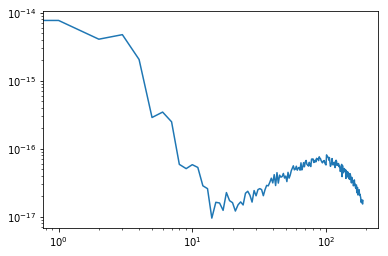

In [23]:
fig, ax = plt.subplots(1, 1)
ax.loglog(res_mean[1,:])

In [9]:
mp_plot=maps[3][1]*large_mask
mp_plot[large_mask<=0]=hp.UNSEEN

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


ValueError: operands could not be broadcast together with shapes (4,193) (4,190) (4,193) 

In [ ]:
cls = run_simulations()
maps = cmb_sims(nside, cls)
mask = np.ones(hp.nside2npix(nside))
cls_comp = run_nama(mask, maps)
cls_ana = hp.anafast(maps)

In [ ]:
fig, ax = plt.subplots(1, 1)
b = nmt.NmtBin(nside, nlb=1)
ax.loglog(cls[0])
ax.loglog(cls_ana[0])
ax.loglog(b.get_effective_ells(), cls_comp[0])
ax.loglog(cls[1])
ax.loglog(cls_ana[1])
ax.loglog(b.get_effective_ells(), cls_comp[1])
ax.loglog(cls[2])
ax.loglog(cls_ana[2])
ax.loglog(b.get_effective_ells(), cls_comp[2])

In [ ]:
small_mask = hp.ud_grade(hp.read_map("mask_04000.fits"), nside_out=256)
apo_mask = nmt.mask_apodization(small_mask, 5., apotype="C1")

In [ ]:
cls_small_mask = run_nama(apo_mask, maps, nlb=10)

In [ ]:
b = nmt.NmtBin(nside, nlb=10)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.loglog(cls[0])
ax.loglog(b.get_effective_ells(), cls_small_mask[0])
ax.loglog(cls[1])
ax.loglog(b.get_effective_ells(), cls_small_mask[1])
ax.loglog(cls[2])
ax.loglog(b.get_effective_ells(), cls_small_mask[2])

In [ ]:
mask = hp.read_map("mask_04000.fits")

In [ ]:
filled_mask = np.copy(large_mask)
filled_mask[np.argwhere(large_mask>0)] = 1

In [ ]:
hp.mollview(mask)
hp.mollview(large_mask)
hp.mollview(filled_mask)
print(np.mean(filled_mask))